In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparsePCA
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
raw_train = pd.read_csv('./data/train.csv')
raw_train.drop(['ID'], axis=1, inplace=True)

### wide data, highly sparse

In [4]:
raw_train.shape

(4459, 4992)

### quick snapshot feature importances /w standard error

In [34]:
rfr = RandomForestRegressor(n_estimators=10)

In [35]:
rfr.fit(raw_train[raw_train.columns.difference(['target'])],
        raw_train['target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [57]:
def sample_feature_importance(meta_estimator, n=50):
    sampling_stats = np.vstack([t.feature_importances_ for t in meta_estimator.estimators_])

    sample_mean = sampling_stats.mean(axis=0)
    descending_mask = np.argsort(sample_mean)[::-1]
    descending_mask = descending_mask[:n]
    return sampling_stats[:, descending_mask], descending_mask

In [58]:
sample_means, indice = feature_importance(rfr)

In [62]:
sample_means.shape

(10, 50)

In [63]:
snapshot = pd.DataFrame(sample_means,
                        columns=raw_train.columns.difference(['target'])[indice])

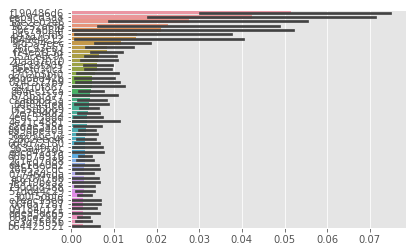

In [65]:
sns.barplot(data=snapshot, ci=95, orient='h')

In [10]:
def rmsle(y, y_pred, epislon=1e-20):
    log_error = np.log(y + epislon) - np.log(y_pred + epislon)
    return np.sqrt(np.mean(np.square(log_error), axis=0))

rmsle_score = make_scorer(rmsle, greater_is_better=False)

### high error in 5-fold cross validation

In [11]:
cross_val_score(rfr,
                raw_train[raw_train.columns.difference(['target'])],
                raw_train['target'],
                cv=5,
                scoring=rmsle_score)

array([-1.64383236, -1.78709736, -1.69112972, -1.80332517, -1.77904197])

In [12]:
spca = SparsePCA(n_components=10, max_iter=100)
std = StandardScaler()

In [13]:
pca_rfr = Pipeline([('Standardize', std), ('SparsePCA', spca), ('RandomForest', rfr)])

In [14]:
cross_val_score(pca_rfr,
                raw_train[raw_train.columns.difference(['target'])],
                raw_train['target'],
                cv=5,
                scoring=rmsle_score)

array([-2.57471747, -2.47274337, -2.50432333, -2.73277261, -2.58632308])

In [15]:
xgr = XGBRegressor(n_estimators=10)

In [16]:
pca_xgr = Pipeline([('Standardize', std), ('SparsePCA', spca), ('RandomForest', xgr)])

In [17]:
cross_val_score(pca_xgr,
                raw_train[raw_train.columns.difference(['target'])],
                raw_train['target'],
                cv=5,
                scoring=rmsle_score)

array([-1.87886333, -2.09152342, -1.89882339, -2.04261579, -2.01913983])